<center><h1>Data-driven football betting strategy</h1></center>
<hr>
### Author(s)

- Dyian Lim (@Dyian Lim)

- Li Jing Cheng (@Jing Cheng)

# Executive Summary

Football betting is one of the most popular gambling activity today and betting sites often offer a mulititude of bet types to punters. Bookmakers in turn generate revenue by factoring in an overround to the odds that are offered to punters. These odds are then updated live until the start of the match based on the betting amounts placed by punters in a manner that reduces the total exposure of bookmakers to one side of a bet. Considering this, coupled with the tendency for most gamblers to rely on intuition, we will attempt to create a system that places value bets when they are available.

# Research Topic & Hypothesis


The first topic of interest is to consider the relationship between the different match statistics and the number of goals scored or conceded. Some examples of the statistics we will attempt to collect include ball possession, pass accuracy (%), corners, fouls, shot accuracy(%), offsides, tackles won, headers won, etc. We will evaluate this relationship with the use of historical data available (e.g. matches played in English Premier League from the 2010/11 to 2017/18 season). 

In the above mentioned step, we utlizied data-cleaning techniques, visualizations, modelling and web scrapping for data collection. After identifying the most important predictors, we fitted these variables into a linear regression model that returned the expected goals scored or conceded by the home and away team. 

In the next step, we tested the robustness of the model with the match results of the 2018/19 season (recently ended) by utilizing the match odds for matches in 2018/19 and the match statistics that will be available to us on a rolling basis. We converted the match odds into implied odds for certain events happening (e.g. 2/1 offered on home win will mean a 33% chance of home win in the long run). After which, we used a Poisson distribution to translate the expected goals scored (from our earlier model) into percentages of different events occuring. If the percentages of our model exceeds the implied odds by a certain margin, we will place a bet and record the results of the bet.

The final step involves evaluation the results of all our bets and whether we can generate a statistically significant profit. 

**Literature / Articles referred to:**
- Computing predicted goals ([Link 1](https://www.pinnacle.com/en/betting-articles/Soccer/how-to-calculate-poisson-distribution/MD62MLXUMKMXZ6A8)) retrieved on 13 Jul 2019
- Statistical modelling of football results ([Link 2](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)) retrieved on 13 Jul 2019


**Datasets used:**
- Source 1 ([Link 3](https://www.premierleague.com/)) retrieved on 13 Jul 2019 (Web-scrapped)
- Source 2 ([Link 4](https://www.football-data.co.uk/data.php)) retrieved on 13 Jul 2019 (CSV format)

# Methodology

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
from selenium import webdriver
import re
import time
import csv
from sklearn import linear_model
from scipy.stats import poisson

## _Step 1: Crawling data from the web_

In [ ]:
my_url = 'https://www.premierleague.com/clubs?se=79'
uClient = uReq(my_url)
page_html = uClient.read()
uClient.close()

In [ ]:
clubs_soup = soup(page_html,'html.parser')
clubs_link_div = clubs_soup.find('div',{'class':'indexSection'})
clubs_link_containers = clubs_link_div.findAll('li')

clubs_link_list = []
i = 0
for link in clubs_link_containers:
    club_link = link.a['href']
    club_link = 'https://www.premierleague.com' + club_link
    club_link = re.sub('overview','stats',club_link)
    club_link = club_link + '?se='
    clubs_link_list.append(club_link)

club_names = ['Arsenal','Aston Villa','Bournemouth','Brighton and Hove Albion','Burnley','Chelsea','Crystal Palace','Everton',
             'Leicester City','Liverpool','Manchester City','Manchester United','Newcastle United','Norwich City','Sheffield United',
             'Southampton','Tottenham Hotspur','Watford','West Ham United','Wolverhampton Wonderers']
clubs_link_dict = {}
i = 0

for name in club_names:
    clubs_link_dict[name] = clubs_link_list[i]
    i += 1
clubs_link_dict

In [ ]:
years_dict = {'1992/93':'1','1993/94':'2','1994/95':'3','1995/96':'4','1996/97':'5',
             '1997/98':'6','1998/99':'7','1999/00':'8','2000/01':'9','2001/02':'10',
             '2002/03':'11','2003/04':'12','2004/05':'13','2005/06':'14','2006/07':'15',
              '2007/08':'16','2008/09':'17','2009/10':'18','2010/11':'19','2011/12':'20',
             '2012/13':'21','2013/14':'22','2014/15':'27','2015/16':'42','2016/17':'54',
             '2017/18':'79','2018/19':'210'}

clubs_years_links_dict = {}

for club,link in clubs_link_dict.items():
    for year, id_ in years_dict.items():
        club_year_link = link + id_
        if club not in clubs_years_links_dict:
            clubs_years_links_dict[club] = {}
        clubs_years_links_dict[club][year] = club_year_link
        
clubs_years_links_dict

In [ ]:
headers = ['Year',
 'Goals',
 'Goals per match',
 'Shots',
 'Shots on target',
 'Shooting accuracy %',
 'Penalties scored',
 'Big chances created',
 'Hit woodwork',
 'Passes',
 'Passes per match',
 'Pass accuracy %',
 'Crosses',
 'Cross accuracy %',
 'Clean sheets',
 'Goals conceded',
 'Goals conceded per match',
 'Saves',
 'Tackles',
 'Tackle success %',
 'Blocked shots',
 'Interceptions',
 'Clearances',
 'Headed Clearance',
 'Aerial Battles/Duels Won',
 'Errors leading to goal',
 'Own goals',
 'Yellow cards',
 'Red cards',
 'Fouls',
 'Offsides']


In [ ]:
# clubs_stats = {}

for club in clubs_years_links_dict:
    clubs_stats = {}
    for year,link in clubs_years_links_dict[club].items():
        my_url = link
        driver = webdriver.Chrome()
        driver.get(my_url)
        
        time.sleep(10)
        
        clubs_soup = soup(driver.page_source,'html.parser')
#         year = links_and_years_dict_new[link]

        club_stat_containers = clubs_soup.find_all('div',{'class':'normalStat'})

        for container in club_stat_containers:
            stat = container.text.strip()
            stat = re.sub('\s+',' ',stat)
            stat = re.split('\s',stat)

            stat_title = ''

            for word in stat[:-1]:
                stat_title = stat_title + ' ' +  word
            stat_title = stat_title.strip()
            stat_num = stat[-1]

            if year not in clubs_stats:
                clubs_stats[year] = {}
            clubs_stats[year][stat_title] = stat_num

        df = pd.DataFrame.from_dict(clubs_stats)
        df = df.transpose().reset_index()
        df.rename(columns={'index':'Year'}, inplace=True)
        df = df[headers]
       #df['club'] = str(club) 
        csv_name = club + '_stats_all_years.csv'
        df.to_csv(csv_name)

## _Step 2: Reading data_

In [2]:
path = r'./Data/EPL/EPL_Hist_Data'
all_files = glob.glob(path + "/*.csv")

data = []

#read csv files containing scrapped data
for file in all_files:
    df = pd.read_csv(file, index_col=None, header=0)
    data.append(df)

#combine csv files for different clubs into one data frame
EPL_df = pd.concat(data, axis=0, ignore_index=True, sort=False)

print (EPL_df.shape, '\n')
EPL_df.head()

(571, 33) 



,Unnamed: 0,Year,Goals,Goals per match,Shots,Shots on target,Shooting accuracy %,Penalties scored,Big chances created,Hit woodwork,...,Clearances,Headed Clearance,Aerial Battles/Duels Won,Errors leading to goal,Own goals,Yellow cards,Red cards,Fouls,Offsides,Club
0,0,1992/93,40,0.95,0,0,0%,0,0,0,...,0,0,0,0,1,34,1,0,0,Arsenal
1,1,1993/94,53,1.26,0,0,0%,0,0,0,...,0,0,0,0,2,32,1,0,0,Arsenal
2,2,1994/95,52,1.24,0,0,0%,0,0,0,...,0,0,0,0,2,59,4,0,0,Arsenal
3,3,1995/96,49,1.29,0,0,0%,0,0,0,...,0,0,0,0,0,63,2,0,0,Arsenal
4,4,1996/97,62,1.63,0,0,0%,0,0,0,...,0,0,0,0,3,81,5,0,0,Arsenal


## _Step 3: Cleaning data_

In [3]:
#extract years for later filtering
EPL_df['startYear'] = EPL_df['Year'].str.slice(start=2, stop=4).astype(int)
EPL_df.drop(EPL_df.columns[0], axis=1, inplace=True)

#Filter out seasons before 2008/09 and our test year 2018/19
Cond1 = ((EPL_df['startYear']>=8) & (EPL_df['startYear']<=18))
    
#Exclude zero rows, i.e. when clubs were not in EPL for certain seasons
Cond2 = (EPL_df['Goals']>0)

EPL_cleandf = EPL_df.loc[Cond1 & Cond2]

pd.options.display.max_columns = None
EPL_cleandf.head()

,Year,Goals,Goals per match,Shots,Shots on target,Shooting accuracy %,Penalties scored,Big chances created,Hit woodwork,Passes,Passes per match,Pass accuracy %,Crosses,Cross accuracy %,Clean sheets,Goals conceded,Goals conceded per match,Saves,Tackles,Tackle success %,Blocked shots,Interceptions,Clearances,Headed Clearance,Aerial Battles/Duels Won,Errors leading to goal,Own goals,Yellow cards,Red cards,Fouls,Offsides,Club,startYear
16,2008/09,68,1.79,662,220,33%,5,0,22,"18,991",499.76,83%,"1,069",21%,16,37,0.97,0,875,75%,169,872,"1,280",402,"2,709",6,3,58,3,0,88,Arsenal,8
17,2009/10,83,2.18,660,233,35%,3,0,15,"19,291",507.66,81%,"1,023",18%,14,41,1.08,3,818,75%,180,839,"1,091",326,"2,900",7,2,56,1,0,93,Arsenal,9
18,2010/11,72,1.89,654,238,36%,4,99,23,"20,150",530.26,84%,928,19%,13,43,1.13,0,772,74%,153,709,"1,077",292,"2,636",7,1,65,6,0,93,Arsenal,10
19,2011/12,74,1.95,637,236,37%,2,97,15,"20,599",542.08,85%,896,22%,13,49,1.29,0,751,74%,165,605,766,218,"2,336",13,5,64,4,0,88,Arsenal,11
20,2012/13,72,1.89,597,205,34%,5,70,16,"21,110",555.53,86%,951,19%,14,37,0.97,0,748,79%,174,636,873,261,"2,840",14,0,42,5,0,80,Arsenal,12


In [4]:
pd.options.mode.chained_assignment = None

#Filtering out one specific problematic data point we found
#EPL_cleandf.loc[EPL_cleandf['Shots on target'] > 600]
EPL_cleandf.drop([128], inplace=True)

In [5]:
print(EPL_cleandf.dtypes)

Year                         object
Goals                         int64
Goals per match             float64
Shots                        object
Shots on target               int64
Shooting accuracy %          object
Penalties scored              int64
Big chances created           int64
Hit woodwork                  int64
Passes                       object
Passes per match            float64
Pass accuracy %              object
Crosses                      object
Cross accuracy %             object
Clean sheets                  int64
Goals conceded                int64
Goals conceded per match    float64
Saves                         int64
Tackles                      object
Tackle success %             object
Blocked shots                 int64
Interceptions                object
Clearances                   object
Headed Clearance             object
Aerial Battles/Duels Won     object
Errors leading to goal        int64
Own goals                     int64
Yellow cards                

In [6]:
pd.options.mode.chained_assignment = None

#Converting columns with object types into numerical values
for col in EPL_cleandf.columns:
    if (EPL_cleandf.loc[:, col].dtype == object) & (col != 'Year') & (col != 'Club'): 
        EPL_cleandf[col] = EPL_cleandf[col].astype(str)
        EPL_cleandf[col] = EPL_cleandf[col].apply(lambda x: re.sub("[,.;%']", "", x))
        EPL_cleandf[col] = EPL_cleandf[col].astype(float)

## _Step 4: Analyzing data_

In [7]:
#Potential predictor variables for expected goals scored
offense_df = EPL_cleandf[['Goals','Shots', 'Shots on target', 'Shooting accuracy %', 'Hit woodwork',
       'Passes', 'Pass accuracy %', 'Crosses', 'Cross accuracy %', 'Offsides']]

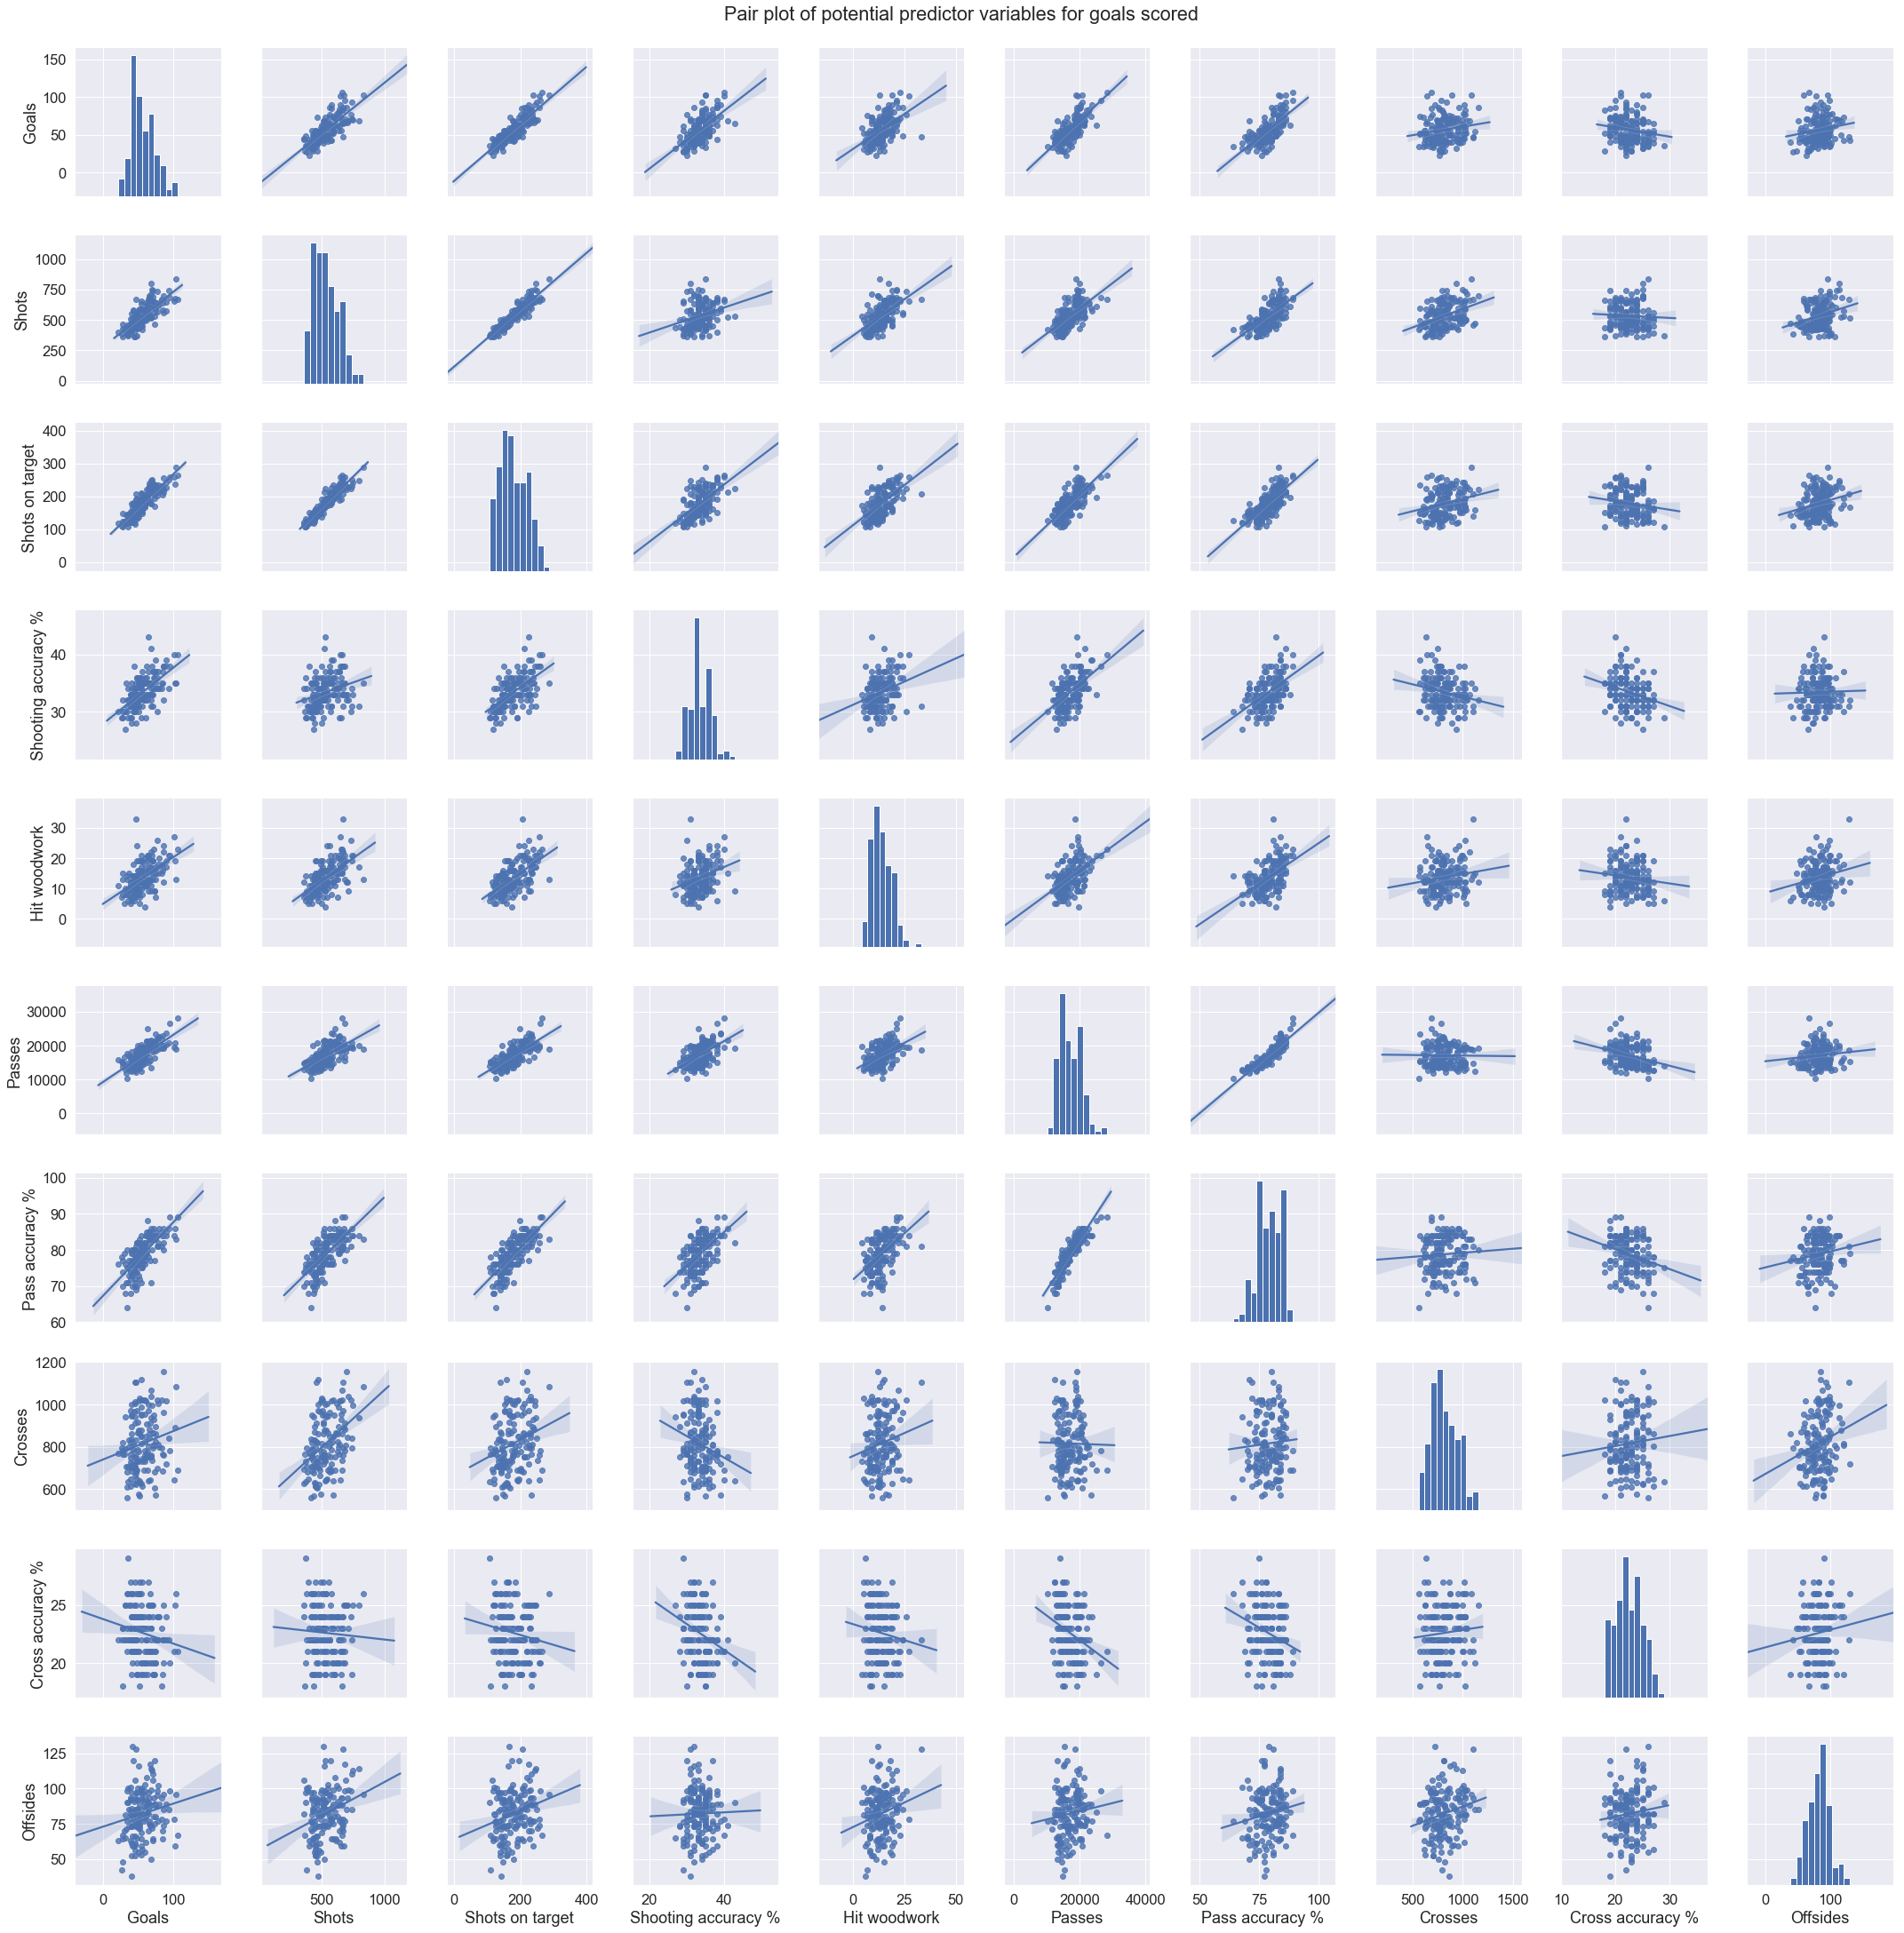

In [8]:
#pair plot for potential predictor variables for expected goals scored
sns.set(font_scale=1.5)
pplot = sns.pairplot(offense_df, dropna=True, kind = 'reg', height=3)
pplot.fig.suptitle("Pair plot of potential predictor variables for goals scored", y =1.01)

plt.show()

In [9]:
offense_df.corr()

,Goals,Shots,Shots on target,Shooting accuracy %,Hit woodwork,Passes,Pass accuracy %,Crosses,Cross accuracy %,Offsides
Goals,1.000000,0.779004,0.881764,0.614005,0.536169,0.760430,0.723876,0.174183,-0.160853,0.169161
Shots,0.779004,1.000000,0.934694,0.282248,0.593113,0.659519,0.697048,0.405990,-0.053897,0.287507
Shots on target,0.881764,0.934694,1.000000,0.597612,0.604336,0.760560,0.772848,0.254152,-0.149379,0.240815
Shooting accuracy %,0.614005,0.282248,0.597612,1.000000,0.291703,0.556460,0.528382,-0.209437,-0.269872,0.023388
Hit woodwork,0.536169,0.593113,0.604336,0.291703,1.000000,0.510664,0.522907,0.161352,-0.120871,0.206646
Passes,0.760430,0.659519,0.760560,0.556460,0.510664,1.000000,0.909711,-0.014326,-0.295426,0.110265
Pass accuracy %,0.723876,0.697048,0.772848,0.528382,0.522907,0.909711,1.000000,0.061201,-0.257169,0.151161
Crosses,0.174183,0.405990,0.254152,-0.209437,0.161352,-0.014326,0.061201,1.000000,0.080749,0.218468
Cross accuracy %,-0.160853,-0.053897,-0.149379,-0.269872,-0.120871,-0.295426,-0.257169,0.080749,1.000000,0.111141
Offsides,0.169161,0.287507,0.240815,0.023388,0.206646,0.110265,0.151161,0.218468,0.111141,1.000000


### _Observations_

- As expected, the number of goals scored share a strong (positive) linear relationship with the number of shots, shots on target and shooting accuracy.

- The number of times the woodwork is hit also shows a fairly strong relationship with goals scored and it may be useful in adjusting for 'unlucky' events in matches.

- Another meaningful explanatory variable when it comes to explaining goals scored are the number of passes made and the passing accuracy.

- Crosses do not appear to correlate with the number of goals scored. Surprisingly, the linear regression line suggests a negative linear relationship between the crossing accuracy and the number of goals scored.

- Offside statistics do not suggest any meaningful relationships with the other variables.

In [10]:
#Potential predictor variables for expected goals conceded
defense_df = EPL_cleandf[['Goals conceded', 'Clean sheets', 'Saves', 'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance',
       'Aerial Battles/Duels Won']]

#remove data points with 0 as entry, due to lack of data collection in earlier seasons for certain stats
defense_df = defense_df[(defense_df[['Goals conceded', 'Clean sheets', 'Saves', 'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance',
       'Aerial Battles/Duels Won']] != 0).all(axis=1)]

#remove data points that have single digit saves, indicating likely data entry error
defense_df = defense_df[defense_df['Saves'] > 38]

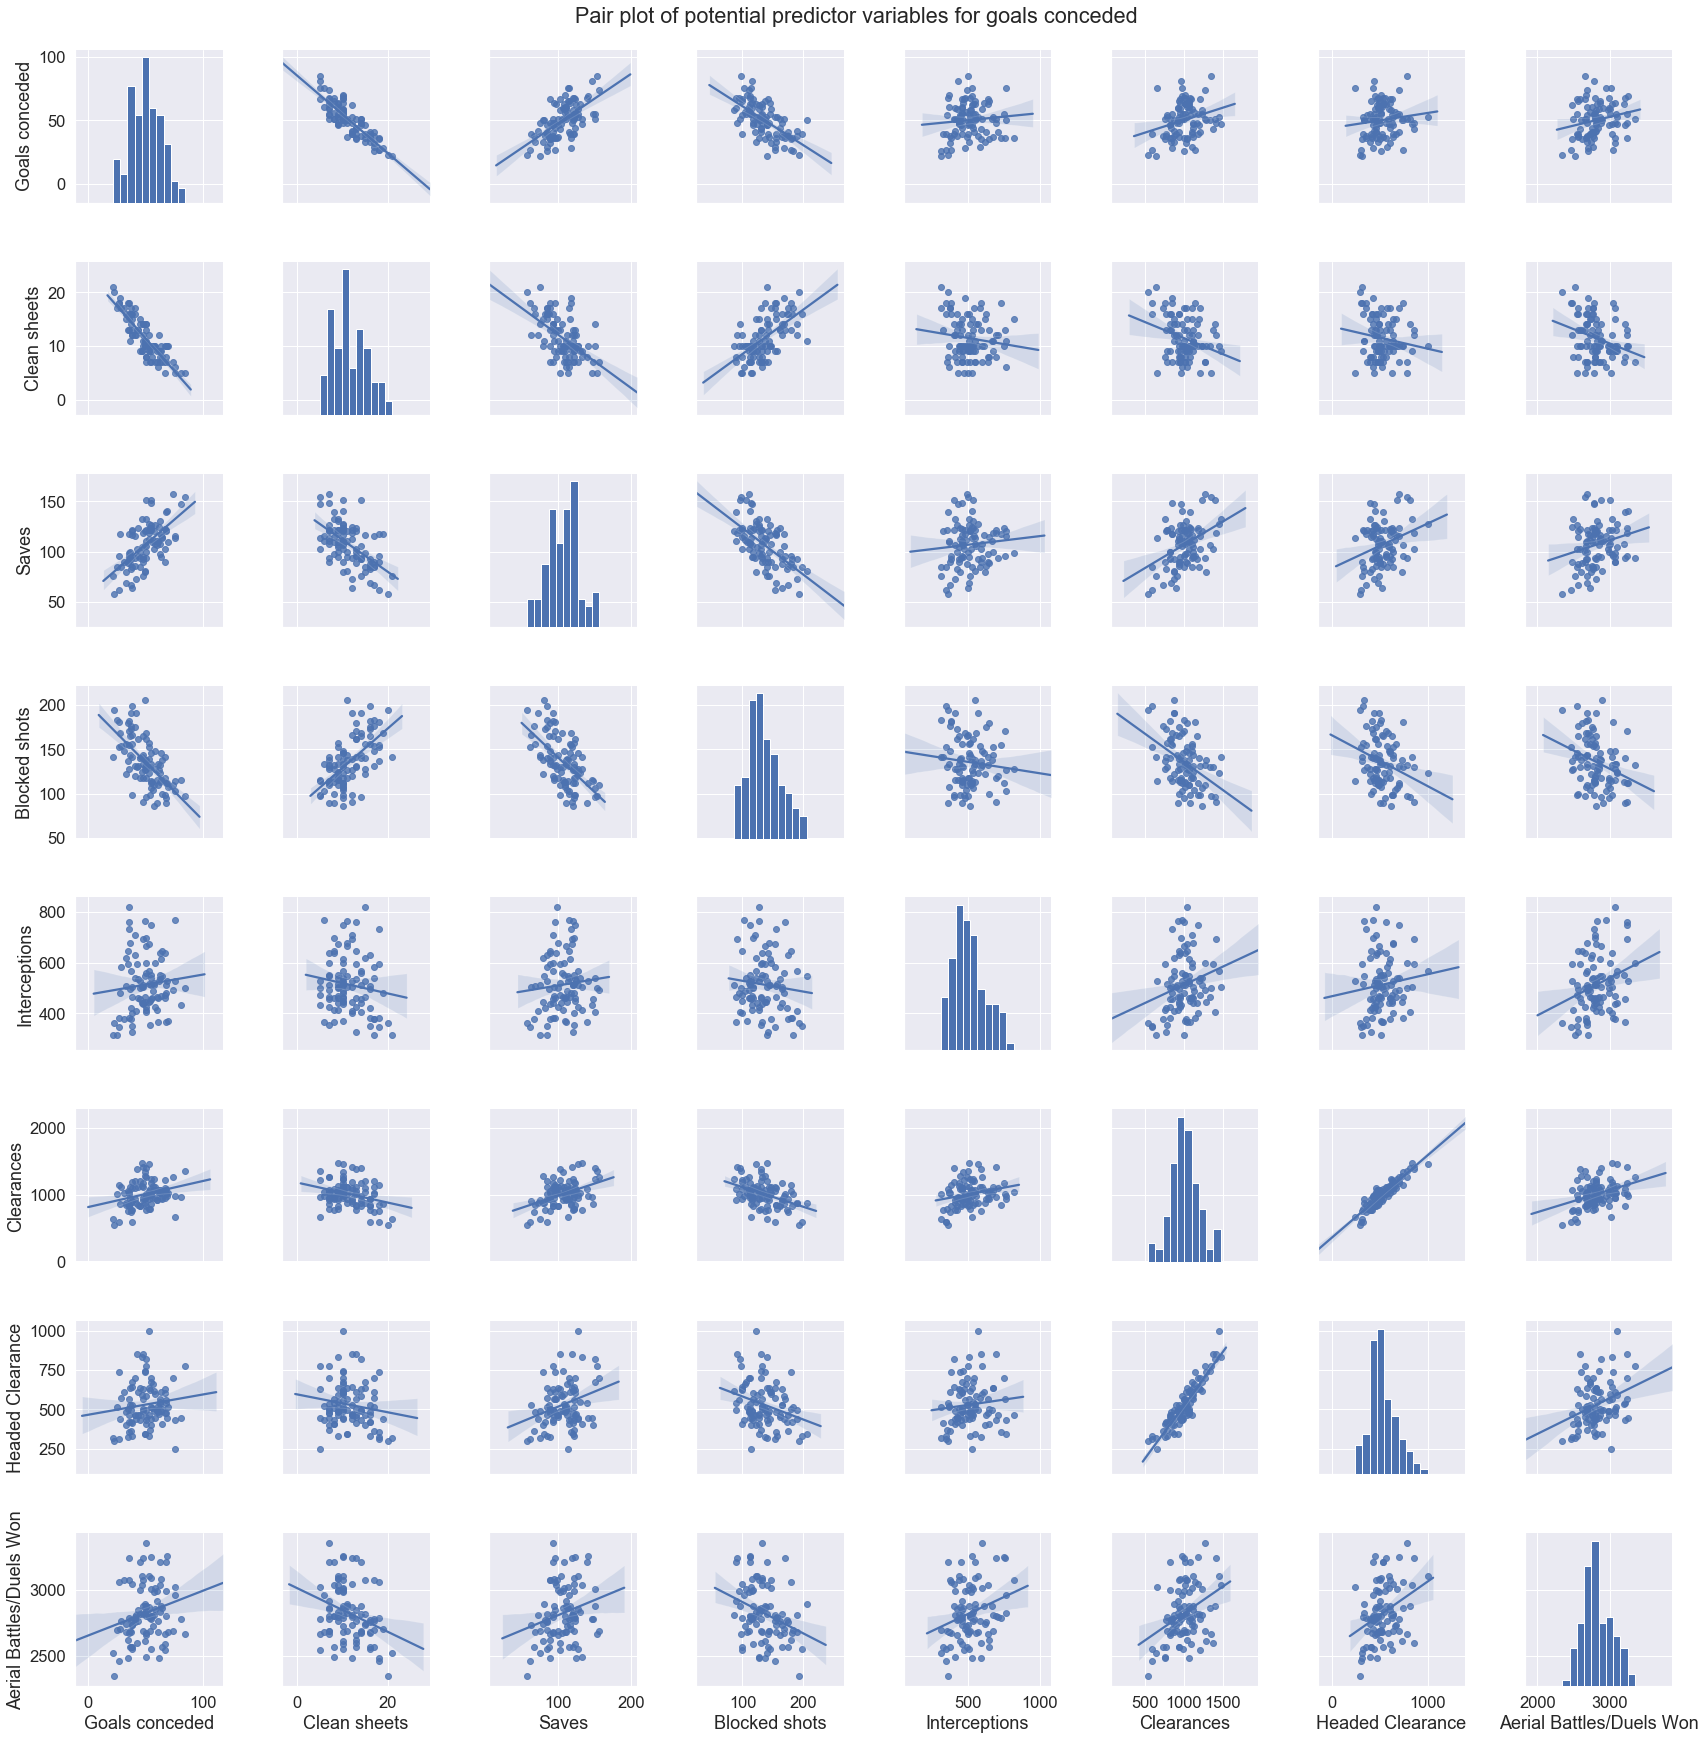

In [11]:
#pair plot for potential predictor variables for expected goals conceded
sns.set(font_scale=1.5)
pplot = sns.pairplot(defense_df, dropna=True, kind = 'reg', height=3)
pplot.fig.suptitle("Pair plot of potential predictor variables for goals conceded", y =1.01)

plt.show()

In [12]:
defense_df.corr()

,Goals conceded,Clean sheets,Saves,Blocked shots,Interceptions,Clearances,Headed Clearance,Aerial Battles/Duels Won
Goals conceded,1.000000,-0.862840,0.622491,-0.633077,0.094597,0.277873,0.124470,0.216879
Clean sheets,-0.862840,1.000000,-0.562139,0.604887,-0.136362,-0.299544,-0.154120,-0.296712
Saves,0.622491,-0.562139,1.000000,-0.599418,0.091074,0.410326,0.293605,0.232792
Blocked shots,-0.633077,0.604887,-0.599418,1.000000,-0.104225,-0.431714,-0.290732,-0.311338
Interceptions,0.094597,-0.136362,0.091074,-0.104225,1.000000,0.240888,0.108399,0.275248
Clearances,0.277873,-0.299544,0.410326,-0.431714,0.240888,1.000000,0.919341,0.366291
Headed Clearance,0.124470,-0.154120,0.293605,-0.290732,0.108399,0.919341,1.000000,0.340393
Aerial Battles/Duels Won,0.216879,-0.296712,0.232792,-0.311338,0.275248,0.366291,0.340393,1.000000


### _Observations_

- Clearly, we would expect that the greater the number of clean sheets kept, the lower the number of goals conceded and we can see this clearly from the scatter plot.

- Intuitively, we would expect that the greater the number of saves made in a match would lead to lesser goals conceded due to an oustanding performance from the keeper. However, the scatter plot suggests a strong positive relationship between the number of saves and number of goals conceded. This makes sense if we consider that teams that are weaker defensively gives away more shot opportunities, leading to more goals conceded as well as saves made by their keeper.

- On the other hand, blocked shots show a strong negative correlation with goals conceded. This is likely due to a stronger and more responsive defense, which in turn puts less pressure on their keeper.

- Interceptions seem to be less useful in predicting goals conceded, and might be better used in assessing midfield performance.

- The same can probably be said about clearances, headed clearances and aerial battles won.

## _Step 5: Building the regression model_

In [13]:
#Build linear regression model for expected goals scored based on statistics per match (38 games played per season)
x_EGS = EPL_cleandf[['Shots on target']]/38
y_EGS = EPL_cleandf[['Goals per match']]
# 'Hit woodwork', 'Passes'
goals_scored_lr = linear_model.LinearRegression()
goals_scored_lr.fit(x_EGS, y_EGS)

#Note: We are using only 1 predictor variable here for the purpose of this project.
#The later testing of our model is on a match to match basis, where we draw data from a seperate source, which do not have
#the same columns as the earlier data frame except for certain key column. 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [14]:
print(goals_scored_lr.coef_)
print(goals_scored_lr.intercept_)

[[0.37725063]]
[-0.29511574]


In [15]:
#Build linear regression model for expected goals conceded based on statistics per match (38 games played per season)
x_EGC = EPL_cleandf[['Clean sheets']]/38
y_EGC = EPL_cleandf[['Goals conceded per match']]
#'Saves', 'Blocked shots'
goals_conceded_lr = linear_model.LinearRegression()
goals_conceded_lr.fit(x_EGC, y_EGC)

#For the same reason as anove, we are only using 1 predictor variable here.

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
print(goals_conceded_lr.coef_)
print(goals_conceded_lr.intercept_)

[[-2.83973123]]
[2.16141851]


## _Step 6: Cleaning another data source for testing_

In [17]:
#Reading in data from downloaded csv, where each row represents a match in the 18/19 season
test_df = pd.read_csv('./Data/EPL/EPL_test/season-1819.csv')
#pd.read_csv("https://www.football-data.co.uk/mmz4281/1819/E0.csv")

test_df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0,1.57,3.9,7.50,1.53,4.0,7.50,1.55,3.80,7.00,1.58,3.93,7.50,1.57,3.8,6.00,1.57,4.0,7.00,39,1.60,1.56,4.20,3.92,8.05,7.06,38,2.12,2.03,1.85,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,12,10,4,1,11,9,7,4,1,1,0,0,1.90,3.6,4.50,1.90,3.4,4.40,1.90,3.50,4.10,1.89,3.63,4.58,1.91,3.5,4.00,1.87,3.6,4.75,39,1.93,1.88,3.71,3.53,4.75,4.37,38,2.05,1.98,1.92,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,15,10,6,9,9,11,5,5,1,2,0,0,2.50,3.4,3.00,2.45,3.3,2.95,2.40,3.30,2.95,2.50,3.46,3.00,2.45,3.3,2.80,2.50,3.4,3.00,39,2.60,2.47,3.49,3.35,3.05,2.92,38,2.00,1.95,1.96,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0,6.50,4.0,1.61,6.25,3.9,1.57,6.20,4.00,1.55,6.41,4.02,1.62,5.80,3.9,1.57,6.50,4.0,1.62,38,6.85,6.09,4.07,3.90,1.66,1.61,37,2.05,1.98,1.90,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0,3.90,3.5,2.04,3.80,3.5,2.00,3.70,3.35,2.05,3.83,3.57,2.08,3.80,3.2,2.05,3.90,3.4,2.10,39,4.01,3.83,3.57,3.40,2.12,2.05,38,2.10,2.01,1.88,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


In [18]:
#Retrieving the relevant columns
test_df = test_df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HST', 'AST', 'BbAvH', 'BbAvD', 'BbAvA', 'BbAv>2.5', 
                   'BbAv<2.5']]
test_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HST,AST,BbAvH,BbAvD,BbAvA,BbAv>2.5,BbAv<2.5
0,10/08/2018,Man United,Leicester,2,1,H,6,4,1.56,3.92,7.06,2.03,1.79
1,11/08/2018,Bournemouth,Cardiff,2,0,H,4,1,1.88,3.53,4.37,1.98,1.83
2,11/08/2018,Fulham,Crystal Palace,0,2,A,6,9,2.47,3.35,2.92,1.95,1.87
3,11/08/2018,Huddersfield,Chelsea,0,3,A,1,4,6.09,3.90,1.61,1.98,1.84
4,11/08/2018,Newcastle,Tottenham,1,2,A,2,5,3.83,3.40,2.05,2.01,1.81


In [19]:
#Creating clean sheet columns for modelling purposes later on
test_df['Home_clean_sheet'] = np.where(test_df['FTAG']==0, 1, 0)
test_df['Away_clean_sheet'] = np.where(test_df['FTHG']==0, 1, 0)
test_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HST,AST,BbAvH,BbAvD,BbAvA,BbAv>2.5,BbAv<2.5,Home_clean_sheet,Away_clean_sheet
0,10/08/2018,Man United,Leicester,2,1,H,6,4,1.56,3.92,7.06,2.03,1.79,0,0
1,11/08/2018,Bournemouth,Cardiff,2,0,H,4,1,1.88,3.53,4.37,1.98,1.83,1,0
2,11/08/2018,Fulham,Crystal Palace,0,2,A,6,9,2.47,3.35,2.92,1.95,1.87,0,1
3,11/08/2018,Huddersfield,Chelsea,0,3,A,1,4,6.09,3.90,1.61,1.98,1.84,0,1
4,11/08/2018,Newcastle,Tottenham,1,2,A,2,5,3.83,3.40,2.05,2.01,1.81,0,0


## _Step 7: Reshaping data_

### Comment: With our earlier model coefficients, we are going to use the averages of earlier matches played during the season as our input for the model. Therefore, our following steps will only start betting after the fifth match of each team when a more stable average can be achieved.

In [20]:
dictOfTeamDF =  {}
for team in test_df['HomeTeam'].unique():
    dictOfTeamDF[team]= test_df[(test_df['HomeTeam']==team) | 
              (test_df['AwayTeam']==team)].reset_index().drop(columns='index')

In [21]:
#This function essentially adds the predicted goals scored and conceded for each team on a rolling average basis.

def add_predictions(teamName, teamDF):
    
    # Shots on target
    accu_SoT = []
    #Clean sheets
    accu_CS = []
    match_records = []

    for index, row in teamDF.iterrows():
        match_record=[]
        if row['HomeTeam']== teamName:
            accu_SoT.append(row['HST'])
            accu_CS.append(row['Home_clean_sheet'])
        else:
            accu_SoT.append(row['AST'])
            accu_CS.append(row['Away_clean_sheet'])

        if index >=4:
            #Shift 1 so that the SoT for the current match played is not taken into account when predicting
            #goals scored, so there is no cheating.
            predicted_GS = (np.array(pd.DataFrame(accu_SoT).shift(1).dropna()).mean() * goals_scored_lr.coef_ + 
                            goals_scored_lr.intercept_)[0][0]
            predicted_GC = (np.array(pd.DataFrame(accu_CS).shift(1).dropna()).mean() * goals_conceded_lr.coef_ + 
                            goals_conceded_lr.intercept_)[0][0]
            match_record.append(row['Date'])
            match_record.append(row['HomeTeam'])
            match_record.append(row['AwayTeam'])
            match_record.append(predicted_GS)
            match_record.append(predicted_GC)
            match_records.append(match_record)

    name= teamName + '_'

    df = pd.DataFrame(match_records, columns=['Date', 'HomeTeam', 'AwayTeam', 
                                              name + 'predicted_GS', name + 'predicted_GC'])
    return df

In [22]:
listOfResultsdf = []

for teamName, teamDF in dictOfTeamDF.items():
    listOfResultsdf.append(add_predictions(teamName, teamDF))

In [23]:
combined_df = test_df
for result in listOfResultsdf:
    combined_df = pd.merge(combined_df, result,  how='left', 
                  left_on=['Date','HomeTeam','AwayTeam'], right_on = ['Date','HomeTeam','AwayTeam'])
combined_df.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HST,AST,BbAvH,BbAvD,BbAvA,BbAv>2.5,BbAv<2.5,Home_clean_sheet,Away_clean_sheet,Man United_predicted_GS,Man United_predicted_GC,Bournemouth_predicted_GS,Bournemouth_predicted_GC,Fulham_predicted_GS,Fulham_predicted_GC,Huddersfield_predicted_GS,Huddersfield_predicted_GC,Newcastle_predicted_GS,Newcastle_predicted_GC,Watford_predicted_GS,Watford_predicted_GC,Wolves_predicted_GS,Wolves_predicted_GC,Arsenal_predicted_GS,Arsenal_predicted_GC,Liverpool_predicted_GS,Liverpool_predicted_GC,Southampton_predicted_GS,Southampton_predicted_GC,Cardiff_predicted_GS,Cardiff_predicted_GC,Chelsea_predicted_GS,Chelsea_predicted_GC,Everton_predicted_GS,Everton_predicted_GC,Leicester_predicted_GS,Leicester_predicted_GC,Tottenham_predicted_GS,Tottenham_predicted_GC,West Ham_predicted_GS,West Ham_predicted_GC,Brighton_predicted_GS,Brighton_predicted_GC,Burnley_predicted_GS,Burnley_predicted_GC,Man City_predicted_GS,Man City_predicted_GC,Crystal Palace_predicted_GS,Crystal Palace_predicted_GC
375,12/05/2019,Liverpool,Wolves,2,0,H,5,2,1.30,5.62,10.17,1.61,2.31,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.224083,1.470673,NaN,NaN,1.958192,0.626429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
376,12/05/2019,Man United,Cardiff,0,2,A,10,4,1.28,6.18,10.10,1.39,2.95,0,1,1.897016,1.624172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.948792,1.470673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,12/05/2019,Southampton,Huddersfield,1,1,D,3,3,1.42,4.81,7.64,1.62,2.29,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.87742,1.777671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.326042,1.624172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,12/05/2019,Tottenham,Everton,2,2,D,3,9,2.09,3.51,3.58,1.76,2.07,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.336238,1.086926,NaN,NaN,1.601333,1.163675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
379,12/05/2019,Watford,West Ham,1,4,A,8,9,2.20,3.73,3.13,1.55,2.44,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.162907,1.624172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.213887,1.624172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#Creating a new data frame with a cleaner interface as compared to the earlier combined_df

predict_df = []
for index, row in combined_df.iterrows():
    row_details = []
    row_details.append(row['Date'])
    row_details.append(row['HomeTeam'])
    row_details.append(row['AwayTeam'])
    row_details.append(row['FTHG'])
    row_details.append(row['FTAG'])
    row_details.append(row['BbAvH'])
    row_details.append(row['BbAvD'])
    row_details.append(row['BbAvA'])
    row_details.append(row['BbAv>2.5'])
    row_details.append(row['BbAv<2.5'])
    hgs = row['HomeTeam'] + '_predicted_GS'
    hgc = row['HomeTeam'] + '_predicted_GC'
    ags = row['AwayTeam'] + '_predicted_GS'
    agc = row['AwayTeam'] + '_predicted_GC'
    
    #In our simulation, the expected goals scored by the home team is a simple average of the results of the goals scored 
    #and goals conceded model
    predict_hgs = (row[hgs] + row[agc])/2
    predict_ags = (row[hgc] + row[ags])/2
    row_details.append(predict_hgs)
    row_details.append(predict_ags)
    predict_df.append(row_details)
    
predict_df = pd.DataFrame(predict_df, columns=['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'BbAvH', 'BbAvD', 
                                              'BbAvA', 'BbAv>2.5', 'BbAv<2.5', 'predict_hgs', 'predict_ags'])

predict_df.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,BbAvH,BbAvD,BbAvA,BbAv>2.5,BbAv<2.5,predict_hgs,predict_ags
375,12/05/2019,Liverpool,Wolves,2,0,1.30,5.62,10.17,1.61,2.31,1.714433,0.925256
376,12/05/2019,Man United,Cardiff,0,2,1.28,6.18,10.10,1.39,2.95,1.683845,1.286482
377,12/05/2019,Southampton,Huddersfield,1,1,1.42,4.81,7.64,1.62,2.29,1.551857,1.250796
378,12/05/2019,Tottenham,Everton,2,2,2.09,3.51,3.58,1.76,2.07,1.344129,1.249957
379,12/05/2019,Watford,West Ham,1,4,2.20,3.73,3.13,1.55,2.44,1.393540,1.419029


In [25]:
#remove the first few rows which have no predictions as data were not available yet
predict_df = predict_df[~(predict_df['predict_hgs'].isna()) & ~(predict_df['predict_ags'].isna())]
predict_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,BbAvH,BbAvD,BbAvA,BbAv>2.5,BbAv<2.5,predict_hgs,predict_ags
40,15/09/2018,Bournemouth,Leicester,4,2,2.42,3.41,2.98,1.88,1.94,1.285530,1.332686
41,15/09/2018,Chelsea,Cardiff,4,1,1.18,7.20,17.53,1.51,2.53,1.354970,0.647626
42,15/09/2018,Huddersfield,Crystal Palace,0,1,3.19,3.11,2.45,2.36,1.59,1.002592,1.521312
43,15/09/2018,Man City,Fulham,3,0,1.12,9.54,21.93,1.26,3.85,2.630779,1.804250
44,15/09/2018,Newcastle,Arsenal,1,2,4.01,3.72,1.91,1.71,2.14,1.499027,1.992875


## _Step 8: Applying Poisson distribution_

In [26]:
#With the expected goals scored and using the Poisson distribution, we can compute probabilities of the different 
#scorelines occuring. e.g. a 0-0 scoreline is simply the product of the PMF for the home team and away team scoring 0 goals,
#assuming independence between these 2 PMFs.

predict_df['0-0'] = predict_df['predict_hgs'].apply(lambda x: poisson.pmf(0, x)) * predict_df['predict_ags'].apply(lambda x: poisson.pmf(0, x)) 

predict_df['1-1'] = predict_df['predict_hgs'].apply(lambda x: poisson.pmf(1, x)) * predict_df['predict_ags'].apply(lambda x: poisson.pmf(1, x))

predict_df['1-0'] = predict_df['predict_hgs'].apply(lambda x: poisson.pmf(1, x)) * predict_df['predict_ags'].apply(lambda x: poisson.pmf(0, x))

predict_df['2-0'] = predict_df['predict_hgs'].apply(lambda x: poisson.pmf(2, x)) * predict_df['predict_ags'].apply(lambda x: poisson.pmf(0, x))

predict_df['0-1'] = predict_df['predict_hgs'].apply(lambda x: poisson.pmf(0, x)) * predict_df['predict_ags'].apply(lambda x: poisson.pmf(1, x))

predict_df['0-2'] = predict_df['predict_hgs'].apply(lambda x: poisson.pmf(0, x)) * predict_df['predict_ags'].apply(lambda x: poisson.pmf(2, x))


#For the purpose of this project, we will evaluate the profitability of betting in the over/under 2.5 types.

#The probability of 2 goals and under is the sum of the 6 scoreline probabilities.
predict_df['under2Goals'] = predict_df['0-0'] + predict_df['1-1'] + predict_df['1-0'] + predict_df['2-0'] + predict_df['0-1'] + predict_df['0-2']

#The remaining probability is for 3 goals and above.
predict_df['over2Goals'] = 1 - predict_df['under2Goals']

predict_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,BbAvH,BbAvD,BbAvA,BbAv>2.5,BbAv<2.5,predict_hgs,predict_ags,0-0,1-1,1-0,2-0,0-1,0-2,under2Goals,over2Goals
40,15/09/2018,Bournemouth,Leicester,4,2,2.42,3.41,2.98,1.88,1.94,1.285530,1.332686,0.072933,0.124949,0.093757,0.060264,0.097197,0.064766,0.513866,0.486134
41,15/09/2018,Chelsea,Cardiff,4,1,1.18,7.20,17.53,1.51,2.53,1.354970,0.647626,0.134984,0.118451,0.182900,0.123912,0.087419,0.028308,0.675974,0.324026
42,15/09/2018,Huddersfield,Crystal Palace,0,1,3.19,3.11,2.45,2.36,1.59,1.002592,1.521312,0.080146,0.122243,0.080354,0.040281,0.121927,0.092745,0.537696,0.462304
43,15/09/2018,Man City,Fulham,3,0,1.12,9.54,21.93,1.26,3.85,2.630779,1.804250,0.011855,0.056269,0.031187,0.041023,0.021389,0.019295,0.181019,0.818981
44,15/09/2018,Newcastle,Arsenal,1,2,4.01,3.72,1.91,1.71,2.14,1.499027,1.992875,0.030443,0.090944,0.045635,0.034204,0.060669,0.060453,0.322348,0.677652


In [27]:
#Creating a column for total goals scored
predict_df['TGS'] = predict_df['FTHG'] + predict_df['FTAG']

#The implied probability is simply the reciprocal of the odds in decimal form (which is as given)
predict_df['implied_over2.5'] = 1 / predict_df['BbAv>2.5']
predict_df['implied_under2.5'] = 1 / predict_df['BbAv<2.5']
predict_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,BbAvH,BbAvD,BbAvA,BbAv>2.5,BbAv<2.5,predict_hgs,predict_ags,0-0,1-1,1-0,2-0,0-1,0-2,under2Goals,over2Goals,TGS,implied_over2.5,implied_under2.5
40,15/09/2018,Bournemouth,Leicester,4,2,2.42,3.41,2.98,1.88,1.94,1.285530,1.332686,0.072933,0.124949,0.093757,0.060264,0.097197,0.064766,0.513866,0.486134,6,0.531915,0.515464
41,15/09/2018,Chelsea,Cardiff,4,1,1.18,7.20,17.53,1.51,2.53,1.354970,0.647626,0.134984,0.118451,0.182900,0.123912,0.087419,0.028308,0.675974,0.324026,5,0.662252,0.395257
42,15/09/2018,Huddersfield,Crystal Palace,0,1,3.19,3.11,2.45,2.36,1.59,1.002592,1.521312,0.080146,0.122243,0.080354,0.040281,0.121927,0.092745,0.537696,0.462304,1,0.423729,0.628931
43,15/09/2018,Man City,Fulham,3,0,1.12,9.54,21.93,1.26,3.85,2.630779,1.804250,0.011855,0.056269,0.031187,0.041023,0.021389,0.019295,0.181019,0.818981,3,0.793651,0.259740
44,15/09/2018,Newcastle,Arsenal,1,2,4.01,3.72,1.91,1.71,2.14,1.499027,1.992875,0.030443,0.090944,0.045635,0.034204,0.060669,0.060453,0.322348,0.677652,3,0.584795,0.467290


In [28]:
#The margin reflects how many % over the implied % before we are willing to bet.
#e.g. if the implied probability of over 2.5 goals is 55% and our model reflects a 58% probability, we will not bet.
#Otherwhise, if our model reflects a 61% probability, we will bet.

margin = 0.05

BetOver = np.where(predict_df['over2Goals'] - margin > predict_df['implied_over2.5'], 1, 0)
BetUnder = np.where(predict_df['under2Goals'] - margin > predict_df['implied_under2.5'], -1, 0)

#1 represents an over 2.5 bet, while -1 represents an under 2.5 bet. 0 indicates no bet.
#It is safe to do this as it is an either-or bet,meaning there will be no scenario where our model indicates a bet for
#both under and over 2.5 in the same match.

predict_df['betPlaced'] = BetOver + BetUnder
predict_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,BbAvH,BbAvD,BbAvA,BbAv>2.5,BbAv<2.5,predict_hgs,predict_ags,0-0,1-1,1-0,2-0,0-1,0-2,under2Goals,over2Goals,TGS,implied_over2.5,implied_under2.5,betPlaced
40,15/09/2018,Bournemouth,Leicester,4,2,2.42,3.41,2.98,1.88,1.94,1.285530,1.332686,0.072933,0.124949,0.093757,0.060264,0.097197,0.064766,0.513866,0.486134,6,0.531915,0.515464,0
41,15/09/2018,Chelsea,Cardiff,4,1,1.18,7.20,17.53,1.51,2.53,1.354970,0.647626,0.134984,0.118451,0.182900,0.123912,0.087419,0.028308,0.675974,0.324026,5,0.662252,0.395257,-1
42,15/09/2018,Huddersfield,Crystal Palace,0,1,3.19,3.11,2.45,2.36,1.59,1.002592,1.521312,0.080146,0.122243,0.080354,0.040281,0.121927,0.092745,0.537696,0.462304,1,0.423729,0.628931,0
43,15/09/2018,Man City,Fulham,3,0,1.12,9.54,21.93,1.26,3.85,2.630779,1.804250,0.011855,0.056269,0.031187,0.041023,0.021389,0.019295,0.181019,0.818981,3,0.793651,0.259740,0
44,15/09/2018,Newcastle,Arsenal,1,2,4.01,3.72,1.91,1.71,2.14,1.499027,1.992875,0.030443,0.090944,0.045635,0.034204,0.060669,0.060453,0.322348,0.677652,3,0.584795,0.467290,1


## _Step 9: Evaluating profit & loss_

In [29]:
#This function calculates the winnings or losses for each match, assuming a $1 bet on each case.
def compute_PL(df):

    if (df['betPlaced']== 1):
        if (df['TGS'] > 2):
            #since odds are given in decimal form, the -1 reflects the return of original bet
            return df['BbAv>2.5'] - 1
        else:
            return -1
        
    elif (df['betPlaced']== -1):
        if (df['TGS'] <= 2):
            return df['BbAv<2.5'] - 1
        else:
            return -1
        
    else:
        return 0

In [30]:
predict_df['PL'] = predict_df.apply(compute_PL, axis = 1)

Ending wealth (assuming $1 bet each time): 8.39
Maximum drawdown: -7.28


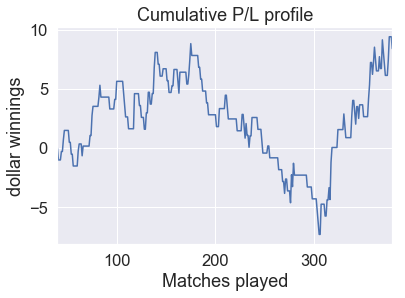

In [31]:
print('Ending wealth (assuming $1 bet each time):', round(predict_df['PL'].sum(), 2))
print('Maximum drawdown:', round(min(predict_df['PL'].cumsum()), 2))


predict_df['PL'].cumsum().plot()
plt.title('Cumulative P/L profile')
plt.xlabel('Matches played')
plt.ylabel('dollar winnings')
plt.show()

# Insights and Evaluation
- From our earlier observations, the predictor variables for the goals are probably well-known by now.
- The cumulatve P/L seems to suggest that predictions improve later on in the season, when teams' performance evaluation is more accurate with the availability of more data.
- There are several limitations with the model, including but not limited to the following:
    - Failure to consider any home advantage and factoring it into the goals scored.
    - Assumption of the same Poisson distribution throughout a single match.
    - Multicollinearity is quite a big problem due to the high correlation between many of the known predictor variables.

We will illustrate the first 2 limitations below.

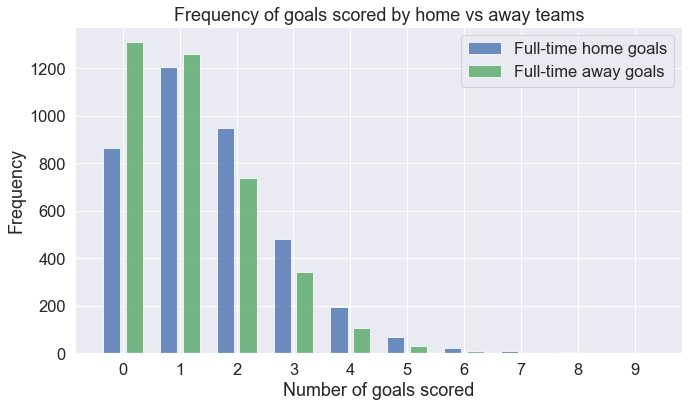

Mean of home goals: 1.55
Mean of away goals: 1.16
Clearly, there is some form of home advantage and teams playing at home can expect to score more goals on average.


In [32]:
path = r'./Data/EPL/original'
all_files = glob.glob(path + "/*.csv")

data = []

for file in all_files:
    df = pd.read_csv(file, index_col=None, header=0)
    data.append(df)

EPL_df = pd.concat(data, axis=0, ignore_index=True, sort=False)

EPL_newdf = EPL_df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 
                   'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'BbAvH', 'BbAvD', 'BbAvA', 'BbAv>2.5', 
                   'BbAv<2.5']]

FTHG = EPL_newdf['FTHG'].value_counts().rename_axis('GS').reset_index(name='HGcounts').sort_values(['GS'])
FTAG = EPL_newdf['FTAG'].value_counts().rename_axis('GS').reset_index(name='AGcounts').sort_values(['GS'])

addRow = {'GS' : 8, 'AGcounts': 0}
addRow2 = {'GS' : 9, 'AGcounts': 0}
FTAG = FTAG.append(addRow, ignore_index=True)
FTAG = FTAG.append(addRow2, ignore_index=True)

minGoals = 0.0
maxGoals = max(max(EPL_newdf['FTHG']), max(EPL_newdf['FTAG']))

# create plot
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(int(maxGoals + 1))
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index-0.2, FTHG['HGcounts'], bar_width,
alpha=opacity,
color='b',
label=('Full-time home goals'))

rects2 = plt.bar(index+0.2, FTAG['AGcounts'], bar_width,
alpha=opacity,
color='g',
label=('Full-time away goals'))

plt.xlabel('Number of goals scored')
plt.ylabel('Frequency')
plt.title('Frequency of goals scored by home vs away teams')
plt.xticks(index)
plt.legend()

plt.tight_layout()
plt.show()

#print statistics here
print('Mean of home goals:', round(EPL_newdf['FTHG'].mean(), 2))
print('Mean of away goals:', round(EPL_newdf['FTAG'].mean(), 2))

print('Clearly, there is some form of home advantage and teams playing at home can expect to score more goals on average.')

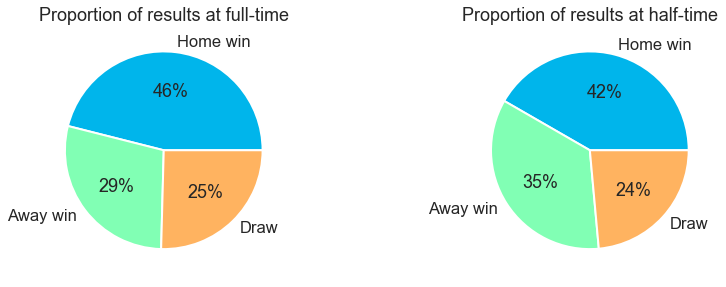

Another illustration of home team advantage


In [33]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax1 = EPL_newdf["FTR"].value_counts().plot.pie(autopct = "%1.0f%%",
                                             colors =sns.color_palette("rainbow",3),
                                             wedgeprops = {"linewidth":2,"edgecolor":"white"},
                                             labels = ['Home win', 'Away win', 'Draw'], ax=ax1)

ax1.set_title("Proportion of results at full-time")
ax1.set_ylabel(None)
ax1.set_xlabel(None)

ax2 = EPL_newdf["HTR"].value_counts().plot.pie(autopct = "%1.0f%%",
                                             colors =sns.color_palette("rainbow",3),
                                             wedgeprops = {"linewidth":2,"edgecolor":"white"},
                                             labels = ['Home win', 'Away win', 'Draw'], ax=ax2)

ax2.set_title("Proportion of results at half-time")
ax2.set_ylabel(None)
ax2.set_xlabel(None)

plt.show()
print('Another illustration of home team advantage')

In [34]:
EPL_newdf['FTGD'] = EPL_newdf['FTHG'] - EPL_newdf['FTAG']
EPL_newdf['HTGD'] = EPL_newdf['HTHG'] - EPL_newdf['HTAG']

EPL_newdf['secHalfHG'] = EPL_newdf['FTHG'] - EPL_newdf['HTHG']
EPL_newdf['secHalfAG'] = EPL_newdf['FTAG'] - EPL_newdf['HTAG']

print ('Goals scored in the first-half')
print ('------------------------------')
print('home team:', EPL_newdf['HTHG'].sum())
print('away team:', EPL_newdf['HTAG'].sum(), '\n')

print ('Goals scored in the second-half')
print ('------------------------------')
print('home team:', EPL_newdf['secHalfHG'].sum())
print('away team:', EPL_newdf['secHalfAG'].sum())

print('\n', 'More goals are scored in the second-half compared to the first-half')

Goals scored in the first-half
------------------------------
home team: 2603.0
away team: 1932.0 

Goals scored in the second-half
------------------------------
home team: 3301.0
away team: 2486.0

 More goals are scored in the second-half compared to the first-half


# Conclusion

- While our model does not appear to generate any significant profits, it is clear that a data-driven approach has the potential to help bettors. Furthermore, the model that we used for this project is fairly trivial utilizing only one predictor.
- The availability and quality of data needed is also fairly important in a project like this. There are a fair number of commercial data providers which could potentially enhance the results of a football prediction model with better quality data. 
- The odds offered by Singapore Pools are a travesty.